#Parte I: Gerar tráfego de chamadas segundo modelo de Erlang-B

1) Entradas: λ = taxa de chegada de chamadas, μ = taxa de saída de chamada, C = quantidade de canais, Q = quantidade de chamadas simuladas.
2) Para cada chamada que chega, gerar um sorteio de uma variável aleatória exponencial com média 1/μ e outra com média 1/λ, representando a saída da chamada e a chegada de uma nova chamada, respectivamente.
3) Computar a ocupação da chamada e reduzir a quantidade de canais disponíveis.
4) Atualizar o calendário de eventos organizando os tempos de cada evento (chegada ou saída) em ordem crescente.
5) Criar um laço que verifica que: (i) se o o evento é uma chegada de chamada, repete-se os passos 2 a 4; (ii) se o evento é uma saída de chamada, apenas a ocupação é atualizada (canal volta a ser disponível) e repete-se o passo 4.
6) O laço deve-se repetir por Q chamadas.
7) As chamadas que não forem atendidas por falta de canais devem ser computadas para cálculo da taxa de bloqueio (chamadas bloqueadas/total de chamadas geradas).
8) Crie uma função que calcule de forma recursiva a probabilidade de bloqueio segundo a fórmula de Erlang-B.
9) Varie os valores das entradas e plote gráficos de convergência da taxa de bloqueio obtida pelo simulador com a probabilidade de bloqueio obtida com a sua função. Aumento o valor de Q de forma gradativa de modo a encontrar a quantidade de chamadas em que a taxa e o bloqueio convergem com um erro ε.
10) Crie um exemplo de entradas na qual encontre a quantidade de canais que garante uma probabilidade (taxa) de bloqueio de 1%. Compare o tempo de execução da sua função e do seu simulador a medida que a carga ρ=λ/μ aumenta.

In [103]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math

In [104]:
def simulate_erlang_b_list(lambd, mu, C, Q):
    tempo_atual = 0.0
    canais_ocupados = 0
    chamadas_bloqueadas = 0
    total_chamadas = 0

    # Calendário de eventos: lista de tuplas [(tempo, tipo)]
    # Tipo 0: Chegada | Tipo 1: Saída
    calendario = []
    lista_canais_ocupados = []

    # Etapa 2: Primeira chegada
    primeira_chegada = np.random.exponential(1/lambd)
    print(f"primeira chegada: {primeira_chegada}")
    calendario.append((primeira_chegada, 0))
    print(f"Calendário inicial: {calendario}")

    while total_chamadas < Q:
        # Etapa 4: Atualizar calendário (ordenar e pegar o mais próximo)
        calendario.sort() # Ordena pelo tempo
        tempo_evento, tipo_evento = calendario.pop(0) # Extrai o menor
        tempo_atual = tempo_evento
        print(f"Canais ocupados atualmente: {canais_ocupados}\n")


        # Etapa 5: Verificar se é chegada ou saída
        if tipo_evento == 0:
            total_chamadas += 1

            # Agenda próxima chegada (Volta pra etapa 2)
            tempo_prox_chegada = tempo_atual + np.random.exponential(1/lambd)
            calendario.append((tempo_prox_chegada, 0))

            # Etapa 3: Ocupação
            if canais_ocupados < C:
                canais_ocupados += 1
                # Agenda saída (Etapa 2)
                service_duration = np.random.exponential(1/mu)
                calendario.append((tempo_atual + service_duration, 1))
                lista_canais_ocupados.append((tempo_evento,tipo_evento))
                print(f"Lista dos canais ocupados: {lista_canais_ocupados}")
                print(f"Canais ocupados atualmente: {canais_ocupados}\n")


            else:
                # Etapa 7: Contar bloqueios
                chamadas_bloqueadas += 1
                print("Chamada bloqueada!\n")

        # Etapa 5: Se for saída, liberar canal e registrar
        elif tipo_evento == 1:
            canais_ocupados -= 1 # Canal volta a ficar disponível
            print(f"Canal liberado!\n")
            lista_canais_ocupados.pop(0)

        print(f"Calendário atual: {calendario}")

    return chamadas_bloqueadas / total_chamadas

In [105]:
# --- Etapa 8: Função Erlang-B Recursiva ---
def erlang_b_recursive(C, rho):
    if C == 0:
        return 1.0
    prev_b = erlang_b_recursive(C - 1, rho)
    return (rho * prev_b) / (C + rho * prev_b)

A saída de streaming foi truncada nas últimas 5000 linhas.
Canal liberado!

Calendário atual: [(972.5262891337134, 0), (972.6501594479698, 1), (972.75034160153, 1), (973.0025547284284, 1), (973.7946057075666, 1), (974.0575294022145, 1), (974.8928397560226, 1)]
Canais ocupados atualmente: 6

Lista dos canais ocupados: [(972.1875853425869, 0), (972.1953136037731, 0), (972.2185050370383, 0), (972.2722621981055, 0), (972.2805140068645, 0), (972.4588165806962, 0), (972.5262891337134, 0)]
Canais ocupados atualmente: 7

Calendário atual: [(972.6501594479698, 1), (972.75034160153, 1), (973.0025547284284, 1), (973.7946057075666, 1), (974.0575294022145, 1), (974.8928397560226, 1), (972.5414575239221, 0), (972.6680098384543, 1)]
Canais ocupados atualmente: 7

Lista dos canais ocupados: [(972.1875853425869, 0), (972.1953136037731, 0), (972.2185050370383, 0), (972.2722621981055, 0), (972.2805140068645, 0), (972.4588165806962, 0), (972.5262891337134, 0), (972.5414575239221, 0)]
Canais ocupados atual

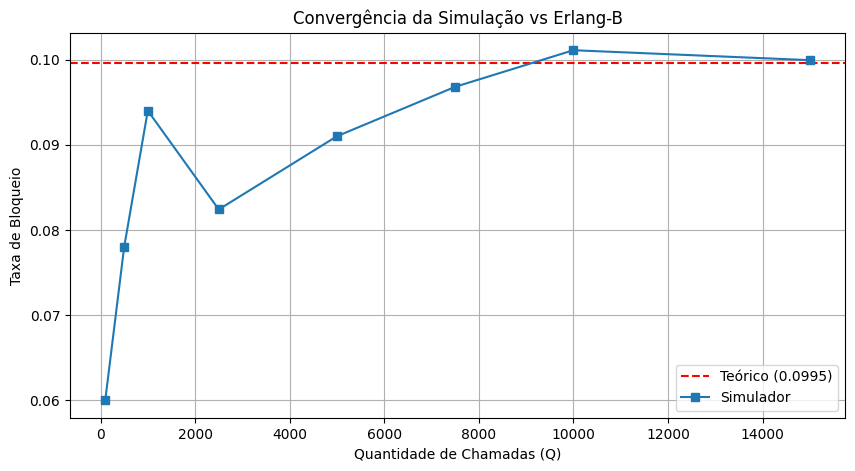

In [170]:
# Parâmetros
lambd, mu, C = 15, 2, 10
b_teorico = erlang_b_recursive(C, lambd/mu)
# qs = [5,10,20,50]
qs = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000]

results = [simulate_erlang_b_list(lambd, mu, C, qs) for qs in qs]

plt.figure(figsize=(10, 5))
plt.axhline(y=b_teorico, color='red', linestyle='--', label=f'Teórico ({b_teorico:.4f})')
plt.plot(qs, results, marker='s', label='Simulador')
plt.xlabel('Quantidade de Chamadas (Q)')
plt.ylabel('Taxa de Bloqueio')
plt.title('Convergência da Simulação vs Erlang-B')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
epsilon_med = 0
for i in results:
  epsilon =  b_teorico - i
  epsilon_med += epsilon
  print(f'epsilon momentâneo: {epsilon}')

print(f'epsilon médio: {epsilon_med/len(results)}')



epsilon momentâneo: 0.009543713056340955
epsilon momentâneo: 0.015543713056340946
epsilon momentâneo: -0.009456286943659048
epsilon momentâneo: -0.0016562869436590466
epsilon momentâneo: 0.01854371305634095
epsilon momentâneo: 0.007277046389674288
epsilon momentâneo: 0.0035437130563409497
epsilon momentâneo: 0.0011437130563409503
epsilon médio: 0.005560379723007618


In [108]:
results

[0.09, 0.084, 0.109, 0.1012, 0.081, 0.09226666666666666, 0.096, 0.0984]

In [109]:
# 1. Encontrar C para 1% com Rho=30
rho = 30
C = 0
while erlang_b_recursive(C, rho) > 0.01:
    C += 1
print(f"Canais para 1% de bloqueio (Rho=30): {C}")
dt_funcs = []
dt_sims = []
# 2. Comparação de tempo de execução
cargas = [1, 5, 10, 20, 30]
# qs = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000]
#
for carga in cargas:
    # Tempo Função
    tempo_inicial = time.time()
    erlang_b_recursive(int(carga*1.2), carga)
    dt_func = time.time() - tempo_inicial

    # Tempo Simulador (Q fixo para comparação justa)
    tempo_inicial = time.time()
    simulate_erlang_b_list(carga, 1, int(carga*1.2), 10000)
    dt_sim = time.time() - tempo_inicial
    dt_funcs.append(dt_func)
    dt_sims.append(dt_sim)
    print(f"Carga ρ={carga} | Tempo Rec: {dt_func:.6f}s | Tempo Sim (List): {dt_sim:.4f}s")

A saída de streaming foi truncada nas últimas 5000 linhas.
Canais ocupados atualmente: 31

Canal liberado!

Calendário atual: [(317.82459595159395, 1), (317.8346353771012, 1), (317.8938142813253, 0), (317.90447560822184, 1), (317.9111121681249, 1), (317.91988766281077, 1), (317.98106739175586, 1), (317.9873844794156, 1), (318.0476589828434, 1), (318.0864426831118, 1), (318.152982936286, 1), (318.16828929322, 1), (318.26107061599066, 1), (318.3522961434569, 1), (318.4478534608198, 1), (318.50808213491797, 1), (318.52208368269714, 1), (318.6766030067382, 1), (318.72010493795045, 1), (318.85903427601545, 1), (318.918032808042, 1), (318.9917390483605, 1), (319.0602506573632, 1), (319.112735443676, 1), (319.3875442653336, 1), (319.4791827287797, 1), (319.69666507810183, 1), (320.4232323775817, 1), (320.9684576280867, 1), (321.0692175335405, 1), (321.9588604514984, 1)]
Canais ocupados atualmente: 30

Canal liberado!

Calendário atual: [(317.8346353771012, 1), (317.8938142813253, 0), (317.904

In [120]:
dt_funcs, dt_sims, cargas

([5.245208740234375e-06,
  1.2636184692382812e-05,
  1.621246337890625e-05,
  1.5974044799804688e-05,
  2.193450927734375e-05],
 [0.38848876953125,
  0.72532057762146,
  1.082002878189087,
  1.7845690250396729,
  2.823122024536133],
 [1, 5, 10, 20, 30])

In [121]:
# 1. Encontrar C para 1% com Rho variável
rhos = [1, 5, 10, 20, 30]
C = 0
for rho in rhos:
  while erlang_b_recursive(C, rho) > 0.01:
      C += 1
  print(f"{C} Canais são necessários para 1% de bloqueio com Rho={rho}")

5 Canais são necessários para 1% de bloqueio com Rho=1
11 Canais são necessários para 1% de bloqueio com Rho=5
18 Canais são necessários para 1% de bloqueio com Rho=10
30 Canais são necessários para 1% de bloqueio com Rho=20
42 Canais são necessários para 1% de bloqueio com Rho=30


# Parte II:  Gerar tráfego de chamadas segundo modelo de Erlang-C


In [111]:
def simulate_erlang_c_list(lambd, mu, C, Q, tempo_max):
    tempo_atual = 0.0
    canais_ocupados = 0
    total_chamadas = 0
    espera_longa = 0

    # Calendário: [(tempo_do_evento, tipo_evento)]
    # Tipo 0: Chegada | Tipo 1: Saída
    calendario = []

    # Lista de espera: Armazena apenas o timestamp de QUANDO a chamada chegou
    lista_tempo_espera = []

    # Inicialização: Primeira chegada
    primeira_chegada = np.random.exponential(1/lambd)
    calendario.append((primeira_chegada, 0))

    while total_chamadas < Q:
        # Ordenação manual (simulando a falta de heapq)
        calendario.sort()

        # Extrai o evento mais próximo
        tempo_evento, tipo_evento = calendario.pop(0)
        tempo_atual = tempo_evento

        # --- TIPO 0: CHEGADA ---
        if tipo_evento == 0:
            total_chamadas += 1

            # 1. Agenda a chegada da PRÓXIMA chamada (para manter o fluxo)
            tempo_prox_chegada = tempo_atual + np.random.exponential(1/lambd)
            calendario.append((tempo_prox_chegada, 0))

            # 2. Verifica disponibilidade
            if canais_ocupados < C:
                # Tem vaga: Atende imediatamente
                canais_ocupados += 1

                # Gera duração e agenda saída
                duracao_servico = np.random.exponential(1/mu)
                calendario.append((tempo_atual + duracao_servico, 1))
            else:
                # Tudo ocupado: Vai para a Fila
                lista_tempo_espera.append(tempo_atual)

        # --- TIPO 1: SAÍDA ---
        elif tipo_evento == 1:
            # Verifica se há alguém na fila para ocupar esse lugar.

            if len(lista_tempo_espera) > 0:
                # Pega  o primeiro da fila
                tempo_chegada_da_chamada = lista_tempo_espera.pop(0)

                # Calcula quanto tempo essa pessoa esperou
                tempo_esperado = tempo_atual - tempo_chegada_da_chamada

                if tempo_esperado > tempo_max:
                    espera_longa += 1

                # O canal continua ocupado mas agora atendendo a pessoa que saiu da fila.
                # Agenda a saída desta nova pessoa
                duracao_servico = np.random.exponential(1/mu)
                calendario.append((tempo_atual + duracao_servico, 1))

            else:
                # Ninguém na fila. O canal realmente fica livre.
                canais_ocupados -= 1

    return espera_longa / total_chamadas

In [144]:
#Etapa 8:

def erlang_c(C, A, t):
    """
    Calcula a probabilidade de espera (Probabilidade de Erlang C, P_W) para
    um sistema M/M/C com intensidade de tráfego A e C canais.

    Args:
        A (float): Intensidade de tráfego (Erlangs). A = lambda / mu.
        C (int): Número de canais.
        t(float): Tempo desejado para calcular a probabilidade.
    Returns:
        float: Probabilidade de que uma chamada tenha que esperar t segundos na fila (P_W>t).
               Retorna 1.0 se a instabilidade for detectada (A >= C).
    """
    A = lambd / mu
    # 1. Verificação de Estabilidade
    # O sistema M/M/C é estável (o regime estacionário existe) apenas se A < C.
    # Se A >= C, a fila crescerá infinitamente, e a probabilidade de espera é 1.0 (ou o modelo não se aplica).
    if A >= C:
        print("Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.")
        return 1.0

    # 2. Cálculo do Termo de Erlang B (Soma Parcial da Série de Poisson)
    # Denominador da Erlang B Parcial (sum_{k=0}^{C-1} A^k / k!)
    soma_erlang_b_parcial = 0.0
    for k in range(C):  # k vai de 0 até C-1
        # Usamos math.exp e math.lgamma (log do fatorial) para melhor estabilidade numérica,
        # mas para valores razoáveis de C (C < 20), math.factorial é mais direto.
        try:
            termo = (A ** k) / math.factorial(k)
        except OverflowError:
            # Caso o factorial(k) seja muito grande, podemos usar a forma logarítmica:
            # termo = exp(k * log(A) - lgamma(k + 1))
            termo = math.exp(k * math.log(A) - math.lgamma(k + 1))

        soma_erlang_b_parcial += termo

    # 3. Cálculo do Termo Principal de C (o termo do estado C)
    # T_c = (A^C / C!) * (C / (C - A))

    # O termo (A^C / C!) é o termo A^k / k! para k=C
    try:
        termo_estado_c = (A ** C) / math.factorial(C)
    except OverflowError:
        termo_estado_c = math.exp(C * math.log(A) - math.lgamma(C + 1))

    fator_c = C / (C - A)
    termo_c_principal = termo_estado_c * fator_c

    # 4. Cálculo da Probabilidade de Espera (Erlang C)
    # P_W = T_c / (soma_erlang_b_parcial + T_c)

    numerador = termo_c_principal
    denominador = soma_erlang_b_parcial + termo_c_principal

    probabilidade_t0 = numerador / denominador

    probabilidade_espera_t = probabilidade_t0 * math.exp( - (( (C- A) * t)/(1/mu)))

    return probabilidade_espera_t

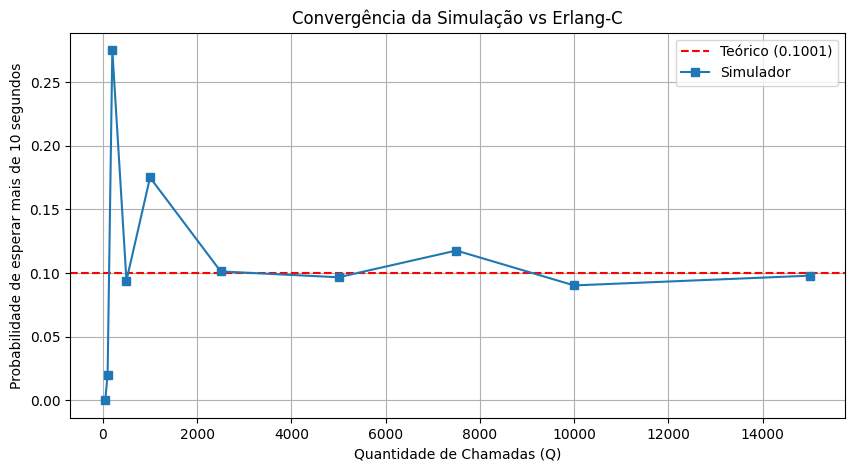

In [164]:
# Parâmetros
# lambd, mu, C, tempo_max = 0.0833, 0.0055, 17, 10
lambd, mu, C, tempo_max = 0.0833, 1.245*0.0055, 17, 10

c_teorico = erlang_c(C, lambd/mu, tempo_max)
qs = [50, 100, 200, 500, 1000, 2500, 5000, 7500, 10000,15000]
# qs = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000]

results = [simulate_erlang_c_list(lambd, mu, C, qs,tempo_max) for qs in qs]

plt.figure(figsize=(10, 5))
plt.axhline(y=c_teorico, color='red', linestyle='--', label=f'Teórico ({c_teorico:.4f})')
plt.plot(qs, results, marker='s', label='Simulador')
plt.xlabel('Quantidade de Chamadas (Q)')
plt.ylabel('Probabilidade de esperar mais de 10 segundos')
plt.title('Convergência da Simulação vs Erlang-C')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
results

[0.0,
 0.02,
 0.275,
 0.094,
 0.175,
 0.1012,
 0.0966,
 0.1176,
 0.0902,
 0.09786666666666667]

In [166]:
epsilon_med = 0
for i in results:
  epsilon =  c_teorico - i
  epsilon_med += epsilon
  print(f'epsilon momentâneo: {epsilon}')

print(f'epsilon médio: {epsilon_med/len(results)}')



epsilon momentâneo: 0.10012911462156104
epsilon momentâneo: 0.08012911462156104
epsilon momentâneo: -0.17487088537843898
epsilon momentâneo: 0.006129114621561044
epsilon momentâneo: -0.07487088537843894
epsilon momentâneo: -0.0010708853784389544
epsilon momentâneo: 0.0035291146215610386
epsilon momentâneo: -0.017470885378438952
epsilon momentâneo: 0.009929114621561042
epsilon momentâneo: 0.0022624479548943727
epsilon médio: -0.006617552045105626


In [168]:
# 1. Encontrar C para 1%
C = 0
while erlang_c(C, lambd/mu,tempo_max) > 0.01:
    C += 1
print(f"{C} Canais para atingir 1% de espera maior que 10 segundos")

Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A probabilidade de espera é teoricamente 1.0.
Aviso: O sistema está instável (A >= C). A 

In [169]:
lambd/mu

12.165023731288791

# Parte III:  Gerar tráfego de chamadas segundo modelo multiclasses de Kaufman


In [132]:
def simulate_kaufman_list(C, classes, Q):
    # Inicialização
    tempo_atual = 0.0
    canais_ocupados = 0
    total_chamadas = 0

    # Contadores por classe
    tipo_chamada = []
    for _ in classes:
        tipo_chamada.append({'geradas': 0, 'bloqueadas': 0})

    # Calendário: [(tempo, tipo, id_classe)] identificador é necessário para identificar qual classe é a chamada
    # Tipo 0: Chegada, Tipo 1: Saída
    calendario = []

    # 1. Agendar a PRIMEIRA chegada de CADA classe
    for i, classe in enumerate(classes):
        primeira_chegada = np.random.exponential(1/classe['lam'])
        calendario.append((primeira_chegada, 0, i))

    while total_chamadas < Q:
        # Ordenação (Simulando falta de heapq)
        calendario.sort()
        tempo_evento, tipo_evento, id_classe = calendario.pop(0)
        tempo_atual = tempo_evento

        classe_props = classes[id_classe] # Propriedades da classe atual

        # --- CHEGADA ---
        if tipo_evento == 0:
            total_chamadas += 1
            tipo_chamada[id_classe]['geradas'] += 1

            # Agenda a próxima chegada DESTA MESMA classe
            prox_chegada = tempo_atual + np.random.exponential(1/classe_props['lam'])
            calendario.append((prox_chegada, 0, id_classe))

            # Tenta Ocupar
            req_canais = classe_props['v']

            if (canais_ocupados + req_canais) <= C:
                # Aceita
                canais_ocupados += req_canais

                # Agenda saída
                duracao = np.random.exponential(1/classe_props['mu'])
                calendario.append((tempo_atual + duracao, 1, id_classe))
            else:
                # Bloqueia
                tipo_chamada[id_classe]['bloqueadas'] += 1

        # --- SAÍDA ---
        elif tipo_evento == 1:
            # Liberta os canais específicos desta classe
            req_canais = classe_props['v']
            canais_ocupados -= req_canais

    # Calcula taxas finais
    resultados_bloqueio = []
    for s in tipo_chamada:
        if s['geradas'] > 0:
            resultados_bloqueio.append(s['bloqueadas'] / s['geradas'])
        else:
            resultados_bloqueio.append(0.0)

    return resultados_bloqueio

In [133]:
def kaufman_roberts_calc(C, classes):
    """
    Calcula a probabilidade de bloqueio para cada classe usando Kaufman.

    Args:
        C (int): Capacidade total de canais.
        classes (list of dict): Lista onde cada dict tem {'lambd', 'mu', 'v'}

    Returns:
        list: Probabilidade de bloqueio teórica para cada classe.
    """
    # 1. Inicialização do vetor de estados (alpha)
    # alpha[j] representa a probabilidade de j canais estarem ocupados
    alpha = [0.0] * (C + 1)
    alpha[0] = 1.0  # Estado base: 0 canais ocupados

    # 2. Recursão de Kaufman
    # j * alpha[j] = Somatório( a_i * alpha[j - v_i] )
    # a_i = (lambda/mu) * v_i

    for j in range(1, C + 1):
        somatorio = 0.0
        for i, classe in enumerate(classes):
            lambd = classe['lambd']
            mu = classe['mu']
            v = classe['v']

            # Só podemos considerar classes que cabem no espaço j
            if j >= v:
                trafego_erlang = lambd / mu
                a_i = trafego_erlang * v
                somatorio += a_i * alpha[j - v]

        alpha[j] = somatorio / j

    # 3. Normalização
    total_alpha = sum(alpha)
    prob_estados = [val / total_alpha for val in alpha] # p_j

    # 4. Cálculo do Bloqueio por Classe (Bi)
    # Bloqueio ocorre se o sistema estiver num estado j onde j > C - v_i
    bloqueios = []
    for classe in classes:
        v = classe['v']
        # Soma as probabilidades dos estados onde não cabem mais v canais
        # Ex: Se C=10 e v=3, bloqueia se estivermos nos estados 8, 9 ou 10.
        prob_b = sum(prob_estados[(C - v + 1):])
        bloqueios.append(prob_b)

    return bloqueios

--- Teórico (Kaufman) para C=2 ---
Classe 0 (v=1): 42.86%
Classe 1 (v=2): 71.43%

--- Simulação (Q=20000) ---
Classe 0: 42.96% (Erro: 0.10%)
Classe 1: 71.02% (Erro: 0.41%)
Tempo de execução: 0.0444s


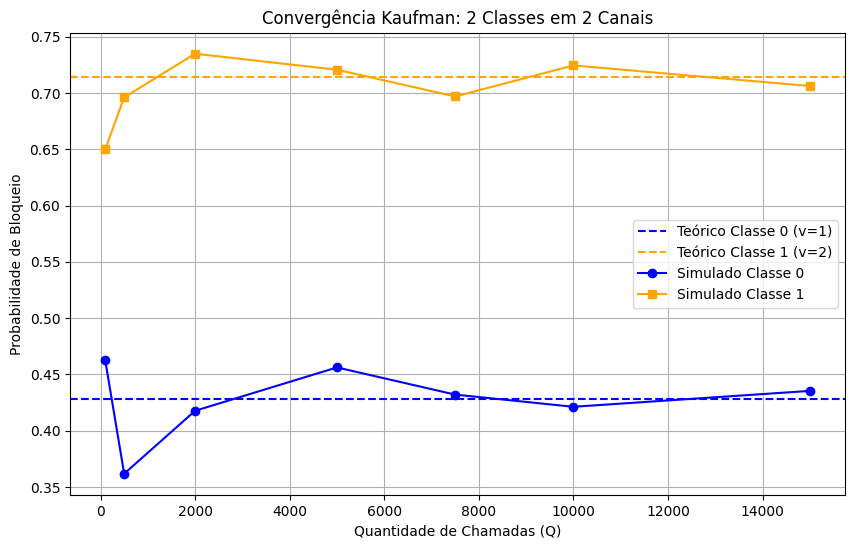

In [139]:
# Seguindo o PDF:
C = 2

# Lista de Classes
classes_exemplo = [
    # Classe 0 - Voz
    {'lam': 2.0, 'mu': 2.0, 'v': 1},

    # Classe 1 - Vídeo
    {'lam': 0.5, 'mu': 0.5, 'v': 2}
]

# 1. Cálculo Teórico (Kaufman)
bloqueio_teorico = kaufman_roberts_calc(C, classes_exemplo)
print(f"--- Teórico (Kaufman) para C={C} ---")
for i, b in enumerate(bloqueio_teorico):
    print(f"Classe {i} (v={classes_exemplo[i]['v']}): {b*100:.2f}%")

# 2. Simulação e Comparação
Q_simulacao = 20000
print(f"\n--- Simulação (Q={Q_simulacao}) ---")
start = time.time()
bloqueio_simulado = simulate_kaufman_list(C, classes_exemplo, Q_simulacao)
end = time.time()

for i, b in enumerate(bloqueio_simulado):
    erro = abs(b - bloqueio_teorico[i])
    print(f"Classe {i}: {b*100:.2f}% (Erro: {erro*100:.2f}%)")

print(f"Tempo de execução: {end - start:.4f}s")

# --- Gráfico de Convergência Multiclasse ---
# Vamos variar Q para mostrar que ambas as classes convergem
q_steps = [100, 500, 2000, 5000, 7500, 10000, 15000]
results_classe0 = []
results_classe1 = []

for q in q_steps:
    res = simulate_kaufman_list(C, classes_exemplo, q)
    results_classe0.append(res[0])
    results_classe1.append(res[1])

plt.figure(figsize=(10, 6))

# Linhas Teóricas
plt.axhline(y=bloqueio_teorico[0], color='blue', linestyle='--', label=f'Teórico Classe 0 (v=1)')
plt.axhline(y=bloqueio_teorico[1], color='orange', linestyle='--', label=f'Teórico Classe 1 (v=2)')

# Linhas Simuladas
plt.plot(q_steps, results_classe0, marker='o', color='blue', label='Simulado Classe 0')
plt.plot(q_steps, results_classe1, marker='s', color='orange', label='Simulado Classe 1')

plt.xlabel('Quantidade de Chamadas (Q)')
plt.ylabel('Probabilidade de Bloqueio')
plt.title(f'Convergência Kaufman: 2 Classes em {C} Canais')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
results_classe0,results_classe1

([0.4625,
  0.36180904522613067,
  0.4177057356608479,
  0.4562327564584901,
  0.4320823646629027,
  0.42125189298334176,
  0.43536453570537864],
 [0.65,
  0.696078431372549,
  0.7348484848484849,
  0.7206317867719645,
  0.6968876860622463,
  0.7244701348747592,
  0.7061595422416694])

In [143]:
epsilon_med0 = 0
print("Classe 0\n")
for i in results_classe0:
  epsilon =  bloqueio_teorico[0] - i
  epsilon_med0 += epsilon
  print(f'epsilon momentâneo: {epsilon}')

print(f'epsilon médio classe 0: {epsilon_med0/len(results_classe0)}')

print("\nClasse 1\n")
epsilon_med1 = 0
for i in results_classe1:
  epsilon =  bloqueio_teorico[1] - i
  epsilon_med1 += epsilon
  print(f'epsilon momentâneo: {epsilon}')

print(f'epsilon médio classe 0: {epsilon_med1/len(results_classe1)}')


Classe 0

epsilon momentâneo: -0.033928571428571475
epsilon momentâneo: 0.06676238334529788
epsilon momentâneo: 0.010865692910580649
epsilon momentâneo: -0.02766132788706155
epsilon momentâneo: -0.003510936091474126
epsilon momentâneo: 0.00731953558808679
epsilon momentâneo: -0.006793107133950094
epsilon médio classe 0: 0.0018648099004154397

Classe 1

epsilon momentâneo: 0.06428571428571417
epsilon momentâneo: 0.0182072829131652
epsilon momentâneo: -0.02056277056277067
epsilon momentâneo: -0.006346072486250298
epsilon momentâneo: 0.01739802822346792
epsilon momentâneo: -0.010184420589045007
epsilon momentâneo: 0.008126172044044755
epsilon médio classe 0: 0.010131990546903724
